In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions as dist
import torchvision
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

In [12]:
plt.rcParams['figure.dpi'] = 200
digits = torch.tensor([0,1,2,3])
torch.nn.functional.one_hot(digits, 10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = torch.utils.data.DataLoader(
    CustomDataset('C:/Users/hegde/Downloads/Dl assignment/val2017', transform=transform),
    batch_size=128,
    shuffle=True
)

In [14]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mean = nn.Linear(512, hidden_dim)
        self.fc3_logvar = nn.Linear(512, hidden_dim)

        self.N = dist.Normal(0, 1)
        self.k1 = 0
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mu = self.fc2_mean(x)
        logvar = self.fc3_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        self.k1 = (sigma**2 + mu**2 - torch.log(sigma) - 1).sum() * 0.5
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 784)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 1, 28, 28)

class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, device)
        self.decoder = Decoder(hidden_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar

  5%|████▏                                                                              | 1/20 [00:12<03:56, 12.43s/it]

Epoch 1, Loss: 187.88531754557292


 10%|████████▎                                                                          | 2/20 [00:24<03:41, 12.28s/it]

Epoch 2, Loss: 165.98625151367187


 15%|████████████▍                                                                      | 3/20 [00:36<03:26, 12.15s/it]

Epoch 3, Loss: 162.73491013997395


 20%|████████████████▌                                                                  | 4/20 [00:48<03:12, 12.04s/it]

Epoch 4, Loss: 160.85565714518228


 25%|████████████████████▊                                                              | 5/20 [01:00<03:00, 12.01s/it]

Epoch 5, Loss: 159.42845862630207


 30%|████████████████████████▉                                                          | 6/20 [01:12<02:47, 11.99s/it]

Epoch 6, Loss: 158.23493346354167


 35%|█████████████████████████████                                                      | 7/20 [01:24<02:37, 12.12s/it]

Epoch 7, Loss: 157.29953033854167


 40%|█████████████████████████████████▏                                                 | 8/20 [01:36<02:25, 12.11s/it]

Epoch 8, Loss: 156.4916155924479


 45%|█████████████████████████████████████▎                                             | 9/20 [01:49<02:14, 12.20s/it]

Epoch 9, Loss: 155.73815424804687


 50%|█████████████████████████████████████████                                         | 10/20 [02:01<02:02, 12.25s/it]

Epoch 10, Loss: 155.14129591471354


 55%|█████████████████████████████████████████████                                     | 11/20 [02:14<01:51, 12.38s/it]

Epoch 11, Loss: 154.50915546875


 60%|█████████████████████████████████████████████████▏                                | 12/20 [02:26<01:38, 12.31s/it]

Epoch 12, Loss: 153.94339837239582


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [02:38<01:25, 12.23s/it]

Epoch 13, Loss: 153.43612174479168


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [02:52<01:16, 12.76s/it]

Epoch 14, Loss: 152.98611801757812


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [03:05<01:04, 12.82s/it]

Epoch 15, Loss: 152.52951881510415


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [03:18<00:51, 12.79s/it]

Epoch 16, Loss: 152.03932744140624


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [03:30<00:37, 12.57s/it]

Epoch 17, Loss: 151.63001761067707


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [03:42<00:25, 12.52s/it]

Epoch 18, Loss: 151.25423865559895


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [03:54<00:12, 12.48s/it]

Epoch 19, Loss: 150.93544842122395


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [04:07<00:00, 12.38s/it]

Epoch 20, Loss: 150.62135950520835


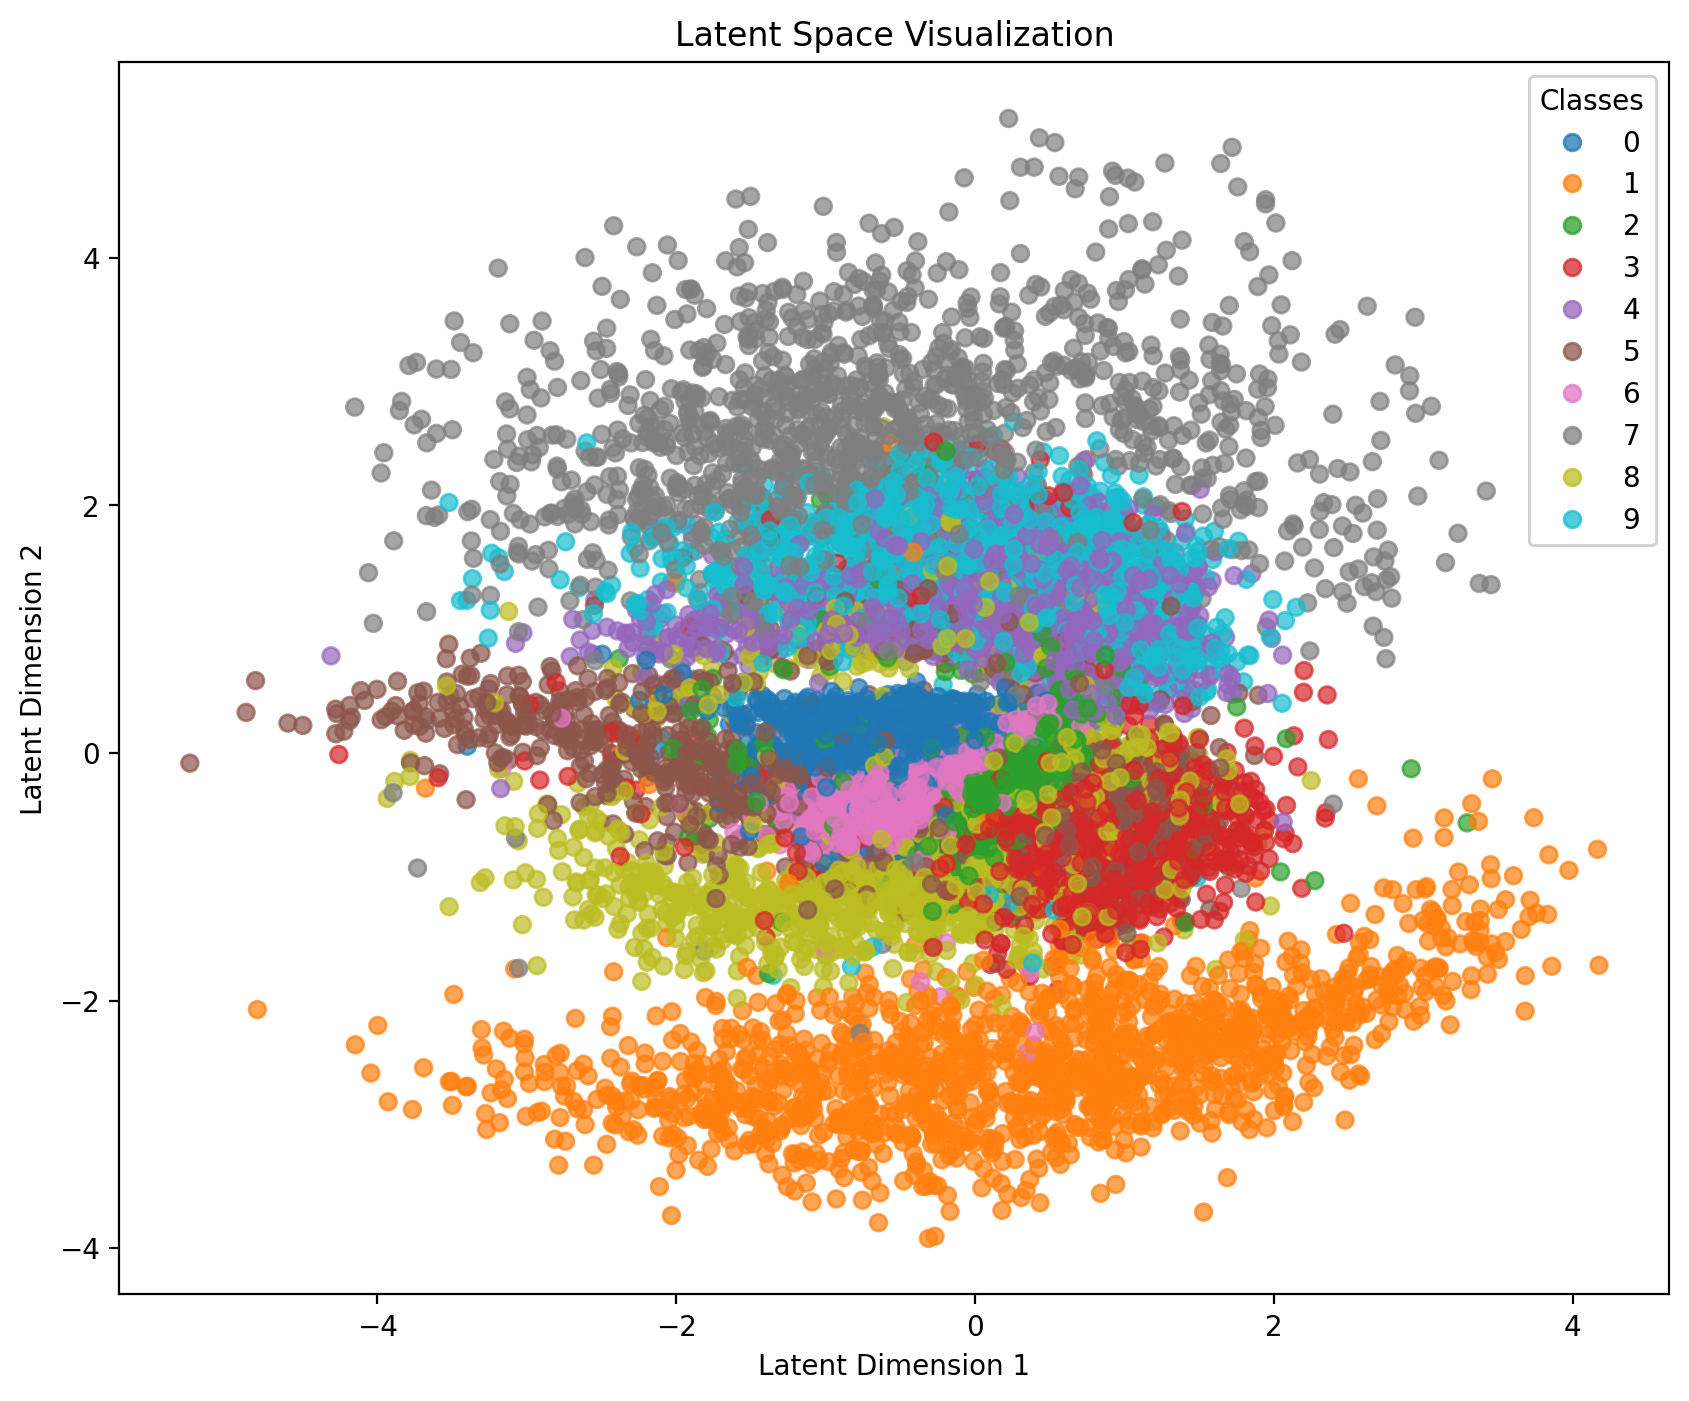

In [16]:
def train_vae(autoencoder, data, device, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    autoencoder.to(device)
    autoencoder.train()

    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for x, _ in data:
            x = x.to(device)
            opt.zero_grad()
            
            # Forward pass
            x_recon, mu, logvar = autoencoder(x)
            
            # Reconstruction loss
            recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
            
            # KL divergence loss
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Total loss
            loss = recon_loss + kld_loss
            loss.backward()
            opt.step()
            
            epoch_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(data.dataset)}')

    return autoencoder

def plot_latent(autoencoder, data, device, num_batches=100):
    autoencoder.eval()
    z_list = []
    label_list = []
    
    with torch.no_grad():
        for i, (x, y) in enumerate(data):
            if i >= num_batches:
                break
            x = x.to(device)
            z, _, _ = autoencoder.encoder(x)
            z_list.append(z.cpu())
            label_list.append(y.cpu())
    
    z = torch.cat(z_list)
    labels = torch.cat(label_list)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10', alpha=0.7)
    legend = plt.legend(*scatter.legend_elements(), title="Classes")
    plt.gca().add_artist(legend)
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.show()

latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device)
vae = train_vae(vae, data, device)

plot_latent(vae, data, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [03:08<00:00,  9.45s/it]


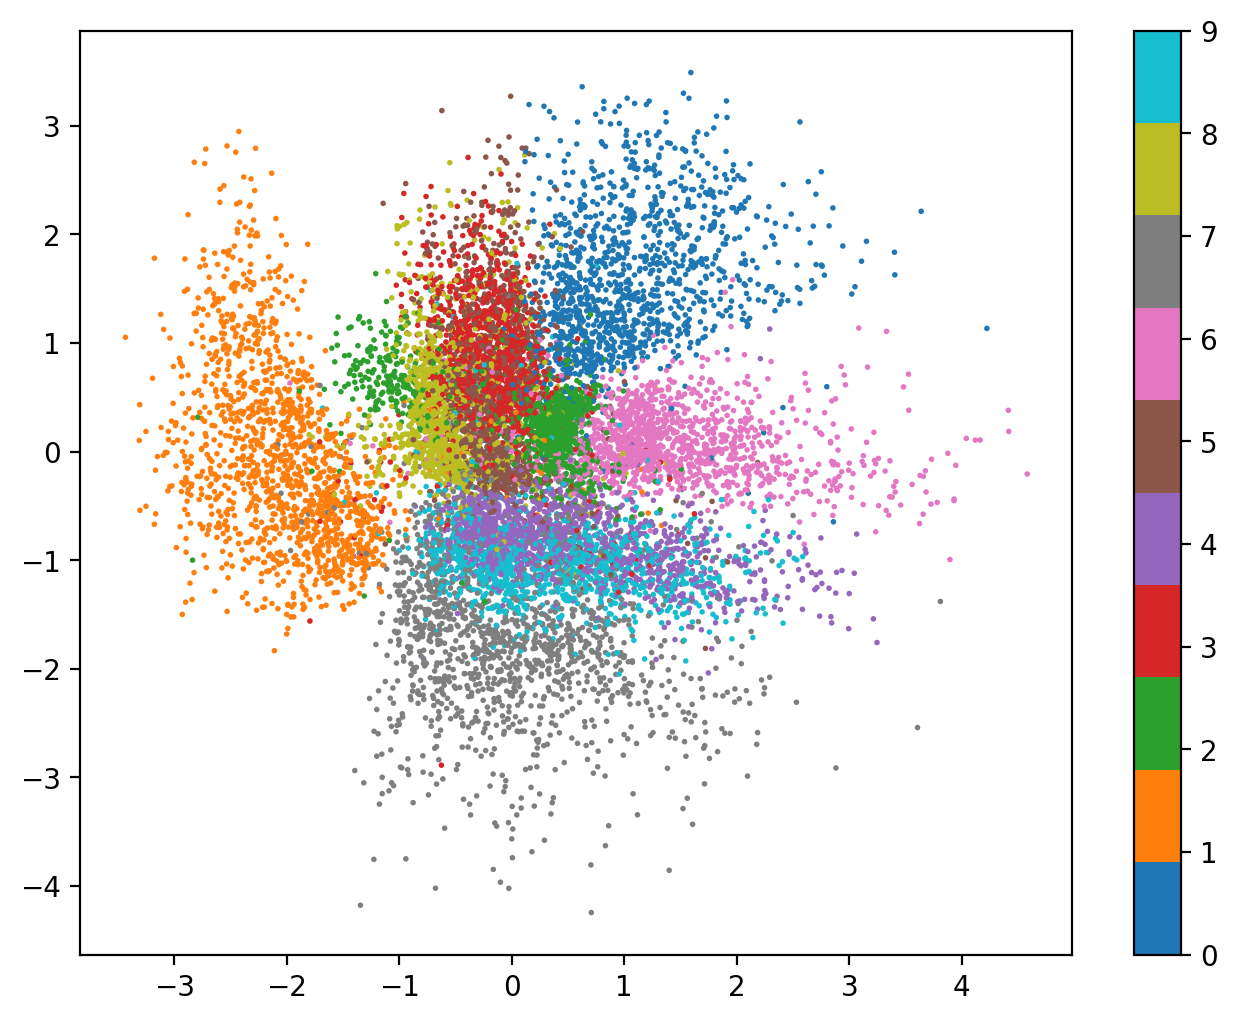

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.distributions as dist
import torchvision
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 200
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load MNIST dataset
data = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/scratch/trose/mnist',
                               transform=torchvision.transforms.ToTensor(),
                               download=True),
    batch_size=128,
    shuffle=True)

class Encoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784, 512)
        self.fc2_mean = nn.Linear(512, hidden_dim)
        self.fc3_logvar = nn.Linear(512, hidden_dim)
        self.N = dist.Normal(0, 1)
        self.device = device

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        mu = self.fc2_mean(x)
        logvar = self.fc3_logvar(x)
        sigma = torch.exp(0.5 * logvar)
        z = mu + sigma * self.N.sample(mu.shape).to(self.device)
        return z, mu, logvar

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(hidden_dim, 512)
        self.fc2 = nn.Linear(512, 784)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_recon = torch.sigmoid(self.fc2(h))
        return x_recon.view(-1, 1, 28, 28)

class VariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim, device):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(hidden_dim, device)
        self.decoder = Decoder(hidden_dim)

    def forward(self, x):
        z, mu, logvar = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, mu, logvar


def train_vae(autoencoder, data, epochs=20):
    opt = torch.optim.Adam(autoencoder.parameters())
    for epoch in tqdm(range(epochs)):
        for x, _ in data:
            x = x.to(device)  # GPU
            opt.zero_grad()
            x_recon, mu, logvar = autoencoder(x)
            recon_loss = ((x - x_recon) ** 2).sum()
            kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            loss = recon_loss + kld_loss
            loss.backward()
            opt.step()
    return autoencoder

def plot_latent(autoencoder, data, num_batches=100):
    plt.figure(figsize=(8, 6))
    for i, (x, y) in enumerate(data):
        z, _, _ = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10', s=1)
        if i >= num_batches:
            break
    plt.colorbar()
    plt.show()

latent_dims = 2
vae = VariationalAutoencoder(latent_dims, device).to(device)
vae = train_vae(vae, data)

plot_latent(vae, data)